In [1]:
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
import statistics

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Data preprocessing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.functional import normalize

In [5]:
edges_df = pd.read_excel(r'~/Downloads/Traffic Speed Prediction Street View Images/Adjacent_Matrix.xls')
target = list(edges_df['TARGET_FID'])
join = list(edges_df['JOIN_FID'])
edge = torch.tensor([target, join], dtype=torch.long)

In [6]:
features_df = pd.read_csv(r'~/Downloads/Traffic Speed Prediction Street View Images/Features.csv')
feature_list = []
for i in range(features_df.shape[0]):
    feature = list(features_df.iloc[i][2: 367])
    feature_list.append(feature)
X_Image = torch.as_tensor(feature_list)

In [7]:
#Create traffic speed for each hour
speed_df = pd.read_csv(r'~/Downloads/Traffic Speed Prediction Street View Images/Y_2.csv')
speed_list = []
for i in range(speed_df.shape[0]):
    speed = list(speed_df.iloc[i][5:29])
    speed_list.append(speed)
Y = torch.as_tensor(speed_list)
X_Speed = Y[:, :12]
Y = Y[:, 12:].float()

In [8]:
network = Data(x=X_Image, y=Y, edge_index=edge)

In [9]:
Mask_df = pd.read_csv(r'~/Downloads/Traffic Speed Prediction Street View Images/Y_2.csv')
Train_Mask_list = list(Mask_df['Train_Mask'])
Train_Mask = torch.as_tensor(Train_Mask_list)

Val_Mask_list = list(Mask_df['Validation_Mask'])
Val_Mask = torch.as_tensor(Val_Mask_list)

Test_Mask_list = list(Mask_df['Test_Mask'])
Test_Mask = torch.as_tensor(Test_Mask_list)

In [10]:
# Dataset is:
### network: contains graph and scene features for each road node, y is speed of 12-11pm
### X_Speed: speed of 0-11am

In [11]:
X_Speed = X_Speed[:, :, None]
print(X_Speed.shape)
print(network.y.shape)

torch.Size([4698, 12, 1])
torch.Size([4698, 12])


### Prepare Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class TrafficSpeedDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data = data_list
        self.transform = transform
        self.x
        self.y
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x
        y
        return x, y

In [14]:
training_dataloader = None
test_dataloader = None

### Network Construction

In [15]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
import os
import random

In [16]:
class Net(torch.nn.Module):
    def __init__(self, time_number):
        super(Net, self).__init__()
        self.time_number = time_number
        self.num_layers = 4
        
        #graph part
        self.conv1 = GCNConv(365, 64)
        self.conv2 = GCNConv(64, 24)
        self.conv3 = GCNConv(24, 12)
        
        self.conv4 = GCNConv(24, 64)
        self.conv5 = GCNConv(64, 24)
        self.conv6 = GCNConv(24, 12)
        
        #Lstm part
        self.lstm = nn.LSTM(
            input_size = 1,
            hidden_size = 12,
            num_layers = self.num_layers,
            batch_first = True
        )
        
    
    def forward(self, graph, time_data):
        x, edge_index = graph.x, graph.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        
        h0 = torch.zeros(self.num_layers, 4698, 12).requires_grad_().float().to(device)
        c0 = torch.zeros(self.num_layers, 4698, 12).requires_grad_().float().to(device)
        
        _, (hn, _) = self.lstm(time_data, (h0, c0))
        
        x_new = torch.cat((x, hn[3]), -1)

        x_new = self.conv4(x_new, edge_index)
        x_new = F.relu(x_new)
        x_new = F.dropout(x_new, training=self.training)
        
        x_new = self.conv5(x_new, edge_index)
        x_new = F.relu(x_new)
        x_new = F.dropout(x_new, training=self.training)
        
        x_new = self.conv6(x_new, edge_index)
        
        return x_new
        
        
        

### Training process

In [17]:
def test_dataset(model, data, result, mask, eva='mape'):
#     print(mask)
    pred = result[mask]
    real = data.y[mask]
#     print(pred.shape)
    err = []
    for i in range(pred.shape[0]):
        pred_y = pred[i][:].cpu().detach().numpy().tolist()
        real_y = real[i][:].cpu().detach().numpy().tolist()
#         print(pred_y)
#         print(real_y)
        if eva=='mape':
            e = metrics.mean_absolute_percentage_error(real_y, pred_y)
        elif eva=='rmse':
            e = sqrt(metrics.mean_squared_error(real_y, pred_y))
        err.append(e)
    return sum(err)/len(err)

In [18]:
def train(model, optimizer, Train_Mask, d1, d2):
    optimizer.zero_grad()
    out = model(d1, d2)
#     print(out.shape)
#     loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
    loss = F.mse_loss(out[Train_Mask], d1.y[Train_Mask])
    loss.float().backward()
    optimizer.step()

def test(model, d1, d2, Mtrain, Mval, Mtest, if_test = False):
    model.eval()
    logits, T_error, V_error = model(d1, d2), [], []
#     print('99999999999999999')
    print(logits.shape)
    print(d1.y.shape)
    
    train_e = test_dataset(model, d1, logits, Mtrain)
    val_e = test_dataset(model, d1, logits, Mval)
#     test_e = test_dataset(model, d1, logits, Mtest)
    if if_test:
        return train_e
    return train_e, val_e

def k_folder_Train(k, epochs, True_list,data, time_data, eva):
    num_validation_samples = len(True_list)//k
    random.shuffle(True_list)
    validation_scores = []
    for fold in range(k):
        validation_mask = True_list[num_validation_samples * fold:num_validation_samples*(fold+1)]
        train_mask = True_list[:num_validation_samples*fold] + True_list[num_validation_samples*(fold+1):]
        
        Train_Mask_list = [False] * Mask_df.shape[0]    
        Val_Mask_list = [False] * Mask_df.shape[0]
        
        for i in validation_mask:
            Val_Mask_list[i] = True
        for j in train_mask:
            Train_Mask_list[i] = True
            
        Train_Mask = torch.as_tensor(Train_Mask_list).to(device)
        Val_Mask = torch.as_tensor(Val_Mask_list).to(device)
        
        model, data, time_data = Net(12).float().to(device), data.to(device), time_data.float().to(device)
#         optimizer = torch.optim.Adam([
#         dict(params=model.conv1.parameters(), weight_decay=5e-4),
#         dict(params=model.conv2.parameters(), weight_decay=0)], lr=0.01)
# #         optimizer.zero_grad()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        print('Start Trainning Fold: ', fold)
        for epoch in range(epochs):
            # trainning
            
            train(model, optimizer, Train_Mask, data, time_data)
            t_ave_e, v_ave_e = test(model, data, time_data, Train_Mask, Val_Mask, Test_Mask,eva)
            validation_scores.append(v_ave_e)
            print('trainning' + str(epoch) + ' :', 'Train Error: ',t_ave_e,'Val Error: ', v_ave_e)
        del model
        torch.cuda.empty_cache()
    return np.average(validation_scores)

In [19]:
Train_Val_M = []
True_list = []
for i in range(len(Train_Mask_list)):
    mask = Train_Mask_list[i] or Val_Mask_list[i]
    if mask:
        True_list.append(i)
    Train_Val_M.append(mask)

In [23]:
def my_loss(predict, real):
#     print(predict.shape)
    loss = torch.mean(torch.sqrt((predict - real)**2)/real)
    return loss

In [88]:
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from sklearn import metrics
from math import sqrt
import random
device = torch.device('cuda')

model = Net(time_number=12)
model.to(device)

learning_rate = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
X_Speed = X_Speed.float().to(device)
network.to(device)
# Training
# eva = 'rmse'
# k_folder_Train(10, 300, True_list,network,X_Speed, eva)
epoch = 2000
val_loss_list = []
train_loss_list = []

val_loss_list_rmse = []
train_loss_list_rmse = []

model_loss = 1000000

for e in range(epoch):
    out = model(network, X_Speed)[:, 4:7]
    y = network.y[:, 4:7]
    optimizer.zero_grad()
    out = model(network, X_Speed)
    y = network.y   
#     print(out-y)
    loss = torch.sqrt(loss_function(out[Train_Mask], y[Train_Mask]).float())
#     loss = my_loss(out[Train_Mask], y[Train_Mask]).float()
#     print(loss)
    
    loss.backward()
    optimizer.step()
    
#     loss_val = loss_function(out[Val_Mask], y[Val_Mask])
    loss_val = my_loss(out[Val_Mask], y[Val_Mask])
    loss_train = my_loss(out[Train_Mask], y[Train_Mask])
    
    loss_train_rmse = torch.sqrt(loss_function(out[Train_Mask], y[Train_Mask]).float())
    loss_val_rmse = torch.sqrt(loss_function(out[Val_Mask], y[Val_Mask].float()))
    
#     print('training error is: ', loss)
    val_loss_list.append(loss_val.cpu().detach().numpy())
    train_loss_list.append(loss_train.cpu().detach().numpy())
    
    val_loss_list_rmse.append(loss_val_rmse.cpu().detach().numpy())
    train_loss_list_rmse.append(loss_train_rmse.cpu().detach().numpy())
    
    if loss_val.cpu().detach().numpy() < model_loss:
        model_loss = loss_val.cpu().detach().numpy()
        name = 'model_best_5_7.pt'
        save_path = os.path.join(r'./Model_Weights', name)
        torch.save(model.state_dict(), save_path)
    if e%500 == 0:
        name = 'model_e_5_7' + str(e) + '.pt'
        save_path = os.path.join(r'./Models', name)
        torch.save(model.state_dict(), save_path)
        
    print("*****************************************************************")
    print('Epoch: ', e, '    train_loss_percentage:', loss_train.cpu().detach().numpy(), ';    ', 'val_loss_percentage:', loss_val.cpu().detach().numpy())
#     print('val_loss_percentage:', loss_val.cpu().detach().numpy())

*****************************************************************
Epoch:  0     train_loss_percentage: 1.0000995 ;     val_loss_percentage: 1.0001084
*****************************************************************
Epoch:  1     train_loss_percentage: 0.9999557 ;     val_loss_percentage: 0.99995244
*****************************************************************
Epoch:  2     train_loss_percentage: 0.9997193 ;     val_loss_percentage: 0.99973905
*****************************************************************
Epoch:  3     train_loss_percentage: 0.999479 ;     val_loss_percentage: 0.99952966
*****************************************************************
Epoch:  4     train_loss_percentage: 0.99933136 ;     val_loss_percentage: 0.9993711
*****************************************************************
Epoch:  5     train_loss_percentage: 0.9991178 ;     val_loss_percentage: 0.9991324
*****************************************************************
Epoch:  6     train_loss_percen

*****************************************************************
Epoch:  57     train_loss_percentage: 0.9121899 ;     val_loss_percentage: 0.9147887
*****************************************************************
Epoch:  58     train_loss_percentage: 0.90655977 ;     val_loss_percentage: 0.9123952
*****************************************************************
Epoch:  59     train_loss_percentage: 0.8983344 ;     val_loss_percentage: 0.90253437
*****************************************************************
Epoch:  60     train_loss_percentage: 0.8904084 ;     val_loss_percentage: 0.89554477
*****************************************************************
Epoch:  61     train_loss_percentage: 0.8828417 ;     val_loss_percentage: 0.8876906
*****************************************************************
Epoch:  62     train_loss_percentage: 0.87565213 ;     val_loss_percentage: 0.8792649
*****************************************************************
Epoch:  63     train_los

*****************************************************************
Epoch:  119     train_loss_percentage: 0.4884688 ;     val_loss_percentage: 0.4787472
*****************************************************************
Epoch:  120     train_loss_percentage: 0.48348755 ;     val_loss_percentage: 0.49770373
*****************************************************************
Epoch:  121     train_loss_percentage: 0.5081298 ;     val_loss_percentage: 0.47786197
*****************************************************************
Epoch:  122     train_loss_percentage: 0.4969006 ;     val_loss_percentage: 0.48006642
*****************************************************************
Epoch:  123     train_loss_percentage: 0.5192711 ;     val_loss_percentage: 0.48639578
*****************************************************************
Epoch:  124     train_loss_percentage: 0.49505192 ;     val_loss_percentage: 0.47015524
*****************************************************************
Epoch:  125    

*****************************************************************
Epoch:  179     train_loss_percentage: 0.39723614 ;     val_loss_percentage: 0.37614912
*****************************************************************
Epoch:  180     train_loss_percentage: 0.3983543 ;     val_loss_percentage: 0.38814268
*****************************************************************
Epoch:  181     train_loss_percentage: 0.38780373 ;     val_loss_percentage: 0.4034184
*****************************************************************
Epoch:  182     train_loss_percentage: 0.39048666 ;     val_loss_percentage: 0.38263154
*****************************************************************
Epoch:  183     train_loss_percentage: 0.3907441 ;     val_loss_percentage: 0.3790007
*****************************************************************
Epoch:  184     train_loss_percentage: 0.3792159 ;     val_loss_percentage: 0.37351242
*****************************************************************
Epoch:  185    

*****************************************************************
Epoch:  238     train_loss_percentage: 0.36509296 ;     val_loss_percentage: 0.34687033
*****************************************************************
Epoch:  239     train_loss_percentage: 0.35612804 ;     val_loss_percentage: 0.34606847
*****************************************************************
Epoch:  240     train_loss_percentage: 0.36928427 ;     val_loss_percentage: 0.3546818
*****************************************************************
Epoch:  241     train_loss_percentage: 0.3517127 ;     val_loss_percentage: 0.34431335
*****************************************************************
Epoch:  242     train_loss_percentage: 0.35360494 ;     val_loss_percentage: 0.34996715
*****************************************************************
Epoch:  243     train_loss_percentage: 0.35223702 ;     val_loss_percentage: 0.35210463
*****************************************************************
Epoch:  244 

*****************************************************************
Epoch:  296     train_loss_percentage: 0.3048277 ;     val_loss_percentage: 0.3296973
*****************************************************************
Epoch:  297     train_loss_percentage: 0.30764663 ;     val_loss_percentage: 0.32310554
*****************************************************************
Epoch:  298     train_loss_percentage: 0.30196542 ;     val_loss_percentage: 0.32427308
*****************************************************************
Epoch:  299     train_loss_percentage: 0.31494007 ;     val_loss_percentage: 0.32249656
*****************************************************************
Epoch:  300     train_loss_percentage: 0.2995478 ;     val_loss_percentage: 0.32496923
*****************************************************************
Epoch:  301     train_loss_percentage: 0.3213008 ;     val_loss_percentage: 0.32178685
*****************************************************************
Epoch:  302   

*****************************************************************
Epoch:  356     train_loss_percentage: 0.28820762 ;     val_loss_percentage: 0.30495924
*****************************************************************
Epoch:  357     train_loss_percentage: 0.27530175 ;     val_loss_percentage: 0.28733814
*****************************************************************
Epoch:  358     train_loss_percentage: 0.2731279 ;     val_loss_percentage: 0.29062298
*****************************************************************
Epoch:  359     train_loss_percentage: 0.2694258 ;     val_loss_percentage: 0.28528836
*****************************************************************
Epoch:  360     train_loss_percentage: 0.2687671 ;     val_loss_percentage: 0.2792513
*****************************************************************
Epoch:  361     train_loss_percentage: 0.27463725 ;     val_loss_percentage: 0.2869311
*****************************************************************
Epoch:  362    

*****************************************************************
Epoch:  415     train_loss_percentage: 0.26672503 ;     val_loss_percentage: 0.26564193
*****************************************************************
Epoch:  416     train_loss_percentage: 0.25989905 ;     val_loss_percentage: 0.26695853
*****************************************************************
Epoch:  417     train_loss_percentage: 0.26434672 ;     val_loss_percentage: 0.26478133
*****************************************************************
Epoch:  418     train_loss_percentage: 0.26114556 ;     val_loss_percentage: 0.26003605
*****************************************************************
Epoch:  419     train_loss_percentage: 0.2636464 ;     val_loss_percentage: 0.26767212
*****************************************************************
Epoch:  420     train_loss_percentage: 0.27092308 ;     val_loss_percentage: 0.27109787
*****************************************************************
Epoch:  421

*****************************************************************
Epoch:  474     train_loss_percentage: 0.26125062 ;     val_loss_percentage: 0.27722958
*****************************************************************
Epoch:  475     train_loss_percentage: 0.26145393 ;     val_loss_percentage: 0.27137277
*****************************************************************
Epoch:  476     train_loss_percentage: 0.27051747 ;     val_loss_percentage: 0.2741349
*****************************************************************
Epoch:  477     train_loss_percentage: 0.25243562 ;     val_loss_percentage: 0.2644117
*****************************************************************
Epoch:  478     train_loss_percentage: 0.25765973 ;     val_loss_percentage: 0.26556125
*****************************************************************
Epoch:  479     train_loss_percentage: 0.26203686 ;     val_loss_percentage: 0.25633216
*****************************************************************
Epoch:  480 

*****************************************************************
Epoch:  533     train_loss_percentage: 0.2630406 ;     val_loss_percentage: 0.26878372
*****************************************************************
Epoch:  534     train_loss_percentage: 0.2584208 ;     val_loss_percentage: 0.26110917
*****************************************************************
Epoch:  535     train_loss_percentage: 0.2585537 ;     val_loss_percentage: 0.2562105
*****************************************************************
Epoch:  536     train_loss_percentage: 0.2630249 ;     val_loss_percentage: 0.25392482
*****************************************************************
Epoch:  537     train_loss_percentage: 0.25083792 ;     val_loss_percentage: 0.26189807
*****************************************************************
Epoch:  538     train_loss_percentage: 0.26071778 ;     val_loss_percentage: 0.2637205
*****************************************************************
Epoch:  539     

*****************************************************************
Epoch:  593     train_loss_percentage: 0.26218337 ;     val_loss_percentage: 0.25983626
*****************************************************************
Epoch:  594     train_loss_percentage: 0.24870417 ;     val_loss_percentage: 0.25660336
*****************************************************************
Epoch:  595     train_loss_percentage: 0.25761306 ;     val_loss_percentage: 0.26725858
*****************************************************************
Epoch:  596     train_loss_percentage: 0.25661284 ;     val_loss_percentage: 0.2756077
*****************************************************************
Epoch:  597     train_loss_percentage: 0.25705472 ;     val_loss_percentage: 0.2645836
*****************************************************************
Epoch:  598     train_loss_percentage: 0.25103566 ;     val_loss_percentage: 0.2639661
*****************************************************************
Epoch:  599  

*****************************************************************
Epoch:  653     train_loss_percentage: 0.26442197 ;     val_loss_percentage: 0.2624063
*****************************************************************
Epoch:  654     train_loss_percentage: 0.26627058 ;     val_loss_percentage: 0.27546427
*****************************************************************
Epoch:  655     train_loss_percentage: 0.25618386 ;     val_loss_percentage: 0.26949856
*****************************************************************
Epoch:  656     train_loss_percentage: 0.24231474 ;     val_loss_percentage: 0.25474784
*****************************************************************
Epoch:  657     train_loss_percentage: 0.25419715 ;     val_loss_percentage: 0.26084006
*****************************************************************
Epoch:  658     train_loss_percentage: 0.24714224 ;     val_loss_percentage: 0.25753036
*****************************************************************
Epoch:  659

*****************************************************************
Epoch:  713     train_loss_percentage: 0.2492306 ;     val_loss_percentage: 0.26277256
*****************************************************************
Epoch:  714     train_loss_percentage: 0.25194517 ;     val_loss_percentage: 0.26204926
*****************************************************************
Epoch:  715     train_loss_percentage: 0.2595092 ;     val_loss_percentage: 0.26361436
*****************************************************************
Epoch:  716     train_loss_percentage: 0.26103473 ;     val_loss_percentage: 0.26224473
*****************************************************************
Epoch:  717     train_loss_percentage: 0.26058644 ;     val_loss_percentage: 0.2607019
*****************************************************************
Epoch:  718     train_loss_percentage: 0.24708118 ;     val_loss_percentage: 0.26170662
*****************************************************************
Epoch:  719  

*****************************************************************
Epoch:  773     train_loss_percentage: 0.25304756 ;     val_loss_percentage: 0.25254986
*****************************************************************
Epoch:  774     train_loss_percentage: 0.24737312 ;     val_loss_percentage: 0.25974384
*****************************************************************
Epoch:  775     train_loss_percentage: 0.24406642 ;     val_loss_percentage: 0.26087174
*****************************************************************
Epoch:  776     train_loss_percentage: 0.2493139 ;     val_loss_percentage: 0.2631754
*****************************************************************
Epoch:  777     train_loss_percentage: 0.23596106 ;     val_loss_percentage: 0.24635364
*****************************************************************
Epoch:  778     train_loss_percentage: 0.25421822 ;     val_loss_percentage: 0.25862858
*****************************************************************
Epoch:  779 

*****************************************************************
Epoch:  833     train_loss_percentage: 0.24162638 ;     val_loss_percentage: 0.26035976
*****************************************************************
Epoch:  834     train_loss_percentage: 0.24871281 ;     val_loss_percentage: 0.26423675
*****************************************************************
Epoch:  835     train_loss_percentage: 0.2535203 ;     val_loss_percentage: 0.2697517
*****************************************************************
Epoch:  836     train_loss_percentage: 0.26190478 ;     val_loss_percentage: 0.2645009
*****************************************************************
Epoch:  837     train_loss_percentage: 0.25239676 ;     val_loss_percentage: 0.26240346
*****************************************************************
Epoch:  838     train_loss_percentage: 0.24241023 ;     val_loss_percentage: 0.2575957
*****************************************************************
Epoch:  839   

*****************************************************************
Epoch:  893     train_loss_percentage: 0.24779047 ;     val_loss_percentage: 0.25565577
*****************************************************************
Epoch:  894     train_loss_percentage: 0.24693666 ;     val_loss_percentage: 0.25604743
*****************************************************************
Epoch:  895     train_loss_percentage: 0.2386974 ;     val_loss_percentage: 0.2632086
*****************************************************************
Epoch:  896     train_loss_percentage: 0.24479337 ;     val_loss_percentage: 0.26381704
*****************************************************************
Epoch:  897     train_loss_percentage: 0.24750598 ;     val_loss_percentage: 0.25997585
*****************************************************************
Epoch:  898     train_loss_percentage: 0.24295546 ;     val_loss_percentage: 0.25637987
*****************************************************************
Epoch:  899 

*****************************************************************
Epoch:  952     train_loss_percentage: 0.23804867 ;     val_loss_percentage: 0.2595582
*****************************************************************
Epoch:  953     train_loss_percentage: 0.23874265 ;     val_loss_percentage: 0.26684314
*****************************************************************
Epoch:  954     train_loss_percentage: 0.24382444 ;     val_loss_percentage: 0.25853685
*****************************************************************
Epoch:  955     train_loss_percentage: 0.24678048 ;     val_loss_percentage: 0.26357624
*****************************************************************
Epoch:  956     train_loss_percentage: 0.25497118 ;     val_loss_percentage: 0.2631868
*****************************************************************
Epoch:  957     train_loss_percentage: 0.24981041 ;     val_loss_percentage: 0.2524935
*****************************************************************
Epoch:  958  

*****************************************************************
Epoch:  1012     train_loss_percentage: 0.2390424 ;     val_loss_percentage: 0.26314119
*****************************************************************
Epoch:  1013     train_loss_percentage: 0.24539192 ;     val_loss_percentage: 0.26161245
*****************************************************************
Epoch:  1014     train_loss_percentage: 0.25318488 ;     val_loss_percentage: 0.26320374
*****************************************************************
Epoch:  1015     train_loss_percentage: 0.23760593 ;     val_loss_percentage: 0.26038548
*****************************************************************
Epoch:  1016     train_loss_percentage: 0.23858568 ;     val_loss_percentage: 0.25246
*****************************************************************
Epoch:  1017     train_loss_percentage: 0.24052478 ;     val_loss_percentage: 0.25948617
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1071     train_loss_percentage: 0.23816562 ;     val_loss_percentage: 0.2642926
*****************************************************************
Epoch:  1072     train_loss_percentage: 0.23669279 ;     val_loss_percentage: 0.2627393
*****************************************************************
Epoch:  1073     train_loss_percentage: 0.23401721 ;     val_loss_percentage: 0.26733828
*****************************************************************
Epoch:  1074     train_loss_percentage: 0.2405047 ;     val_loss_percentage: 0.2579105
*****************************************************************
Epoch:  1075     train_loss_percentage: 0.241195 ;     val_loss_percentage: 0.26744905
*****************************************************************
Epoch:  1076     train_loss_percentage: 0.23989682 ;     val_loss_percentage: 0.26003426
*****************************************************************
Epoch:  10

*****************************************************************
Epoch:  1129     train_loss_percentage: 0.22515093 ;     val_loss_percentage: 0.25592598
*****************************************************************
Epoch:  1130     train_loss_percentage: 0.235045 ;     val_loss_percentage: 0.25552833
*****************************************************************
Epoch:  1131     train_loss_percentage: 0.24849421 ;     val_loss_percentage: 0.28133348
*****************************************************************
Epoch:  1132     train_loss_percentage: 0.24292576 ;     val_loss_percentage: 0.25830236
*****************************************************************
Epoch:  1133     train_loss_percentage: 0.23775391 ;     val_loss_percentage: 0.2526074
*****************************************************************
Epoch:  1134     train_loss_percentage: 0.23590456 ;     val_loss_percentage: 0.2520759
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1190     train_loss_percentage: 0.23785733 ;     val_loss_percentage: 0.26256725
*****************************************************************
Epoch:  1191     train_loss_percentage: 0.23127322 ;     val_loss_percentage: 0.2600262
*****************************************************************
Epoch:  1192     train_loss_percentage: 0.23164414 ;     val_loss_percentage: 0.25806478
*****************************************************************
Epoch:  1193     train_loss_percentage: 0.23954298 ;     val_loss_percentage: 0.25556394
*****************************************************************
Epoch:  1194     train_loss_percentage: 0.24099572 ;     val_loss_percentage: 0.2648681
*****************************************************************
Epoch:  1195     train_loss_percentage: 0.25222012 ;     val_loss_percentage: 0.27001458
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1251     train_loss_percentage: 0.23177317 ;     val_loss_percentage: 0.25540963
*****************************************************************
Epoch:  1252     train_loss_percentage: 0.23089993 ;     val_loss_percentage: 0.25949067
*****************************************************************
Epoch:  1253     train_loss_percentage: 0.24214622 ;     val_loss_percentage: 0.2520006
*****************************************************************
Epoch:  1254     train_loss_percentage: 0.24292304 ;     val_loss_percentage: 0.25778273
*****************************************************************
Epoch:  1255     train_loss_percentage: 0.24515754 ;     val_loss_percentage: 0.2523729
*****************************************************************
Epoch:  1256     train_loss_percentage: 0.23440187 ;     val_loss_percentage: 0.25905856
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1310     train_loss_percentage: 0.237942 ;     val_loss_percentage: 0.26021814
*****************************************************************
Epoch:  1311     train_loss_percentage: 0.2565406 ;     val_loss_percentage: 0.27564538
*****************************************************************
Epoch:  1312     train_loss_percentage: 0.2355826 ;     val_loss_percentage: 0.2725411
*****************************************************************
Epoch:  1313     train_loss_percentage: 0.2308668 ;     val_loss_percentage: 0.26080504
*****************************************************************
Epoch:  1314     train_loss_percentage: 0.23442987 ;     val_loss_percentage: 0.25801754
*****************************************************************
Epoch:  1315     train_loss_percentage: 0.22145508 ;     val_loss_percentage: 0.25960207
*****************************************************************
Epoch:  13

*****************************************************************
Epoch:  1370     train_loss_percentage: 0.24024004 ;     val_loss_percentage: 0.26111296
*****************************************************************
Epoch:  1371     train_loss_percentage: 0.24011028 ;     val_loss_percentage: 0.25835094
*****************************************************************
Epoch:  1372     train_loss_percentage: 0.22601673 ;     val_loss_percentage: 0.2524605
*****************************************************************
Epoch:  1373     train_loss_percentage: 0.22915128 ;     val_loss_percentage: 0.25218636
*****************************************************************
Epoch:  1374     train_loss_percentage: 0.23415743 ;     val_loss_percentage: 0.25642332
*****************************************************************
Epoch:  1375     train_loss_percentage: 0.23313294 ;     val_loss_percentage: 0.26363185
*****************************************************************
Epoch

*****************************************************************
Epoch:  1430     train_loss_percentage: 0.23356056 ;     val_loss_percentage: 0.2595597
*****************************************************************
Epoch:  1431     train_loss_percentage: 0.2236011 ;     val_loss_percentage: 0.2536983
*****************************************************************
Epoch:  1432     train_loss_percentage: 0.23536849 ;     val_loss_percentage: 0.26673743
*****************************************************************
Epoch:  1433     train_loss_percentage: 0.2340996 ;     val_loss_percentage: 0.25511625
*****************************************************************
Epoch:  1434     train_loss_percentage: 0.23507589 ;     val_loss_percentage: 0.26250795
*****************************************************************
Epoch:  1435     train_loss_percentage: 0.23590672 ;     val_loss_percentage: 0.25289154
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1487     train_loss_percentage: 0.22641899 ;     val_loss_percentage: 0.25296184
*****************************************************************
Epoch:  1488     train_loss_percentage: 0.22227342 ;     val_loss_percentage: 0.24773066
*****************************************************************
Epoch:  1489     train_loss_percentage: 0.22752818 ;     val_loss_percentage: 0.25993666
*****************************************************************
Epoch:  1490     train_loss_percentage: 0.23313369 ;     val_loss_percentage: 0.26365423
*****************************************************************
Epoch:  1491     train_loss_percentage: 0.22999959 ;     val_loss_percentage: 0.27031142
*****************************************************************
Epoch:  1492     train_loss_percentage: 0.23573135 ;     val_loss_percentage: 0.26700753
*****************************************************************
Epoc

*****************************************************************
Epoch:  1546     train_loss_percentage: 0.2298951 ;     val_loss_percentage: 0.26093137
*****************************************************************
Epoch:  1547     train_loss_percentage: 0.2316749 ;     val_loss_percentage: 0.26063538
*****************************************************************
Epoch:  1548     train_loss_percentage: 0.22735657 ;     val_loss_percentage: 0.2566991
*****************************************************************
Epoch:  1549     train_loss_percentage: 0.23511651 ;     val_loss_percentage: 0.24518585
*****************************************************************
Epoch:  1550     train_loss_percentage: 0.22631139 ;     val_loss_percentage: 0.26297334
*****************************************************************
Epoch:  1551     train_loss_percentage: 0.22572175 ;     val_loss_percentage: 0.2650307
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1606     train_loss_percentage: 0.2267707 ;     val_loss_percentage: 0.25698578
*****************************************************************
Epoch:  1607     train_loss_percentage: 0.22650422 ;     val_loss_percentage: 0.25488266
*****************************************************************
Epoch:  1608     train_loss_percentage: 0.22637852 ;     val_loss_percentage: 0.2534159
*****************************************************************
Epoch:  1609     train_loss_percentage: 0.23058964 ;     val_loss_percentage: 0.2810775
*****************************************************************
Epoch:  1610     train_loss_percentage: 0.22957735 ;     val_loss_percentage: 0.2528847
*****************************************************************
Epoch:  1611     train_loss_percentage: 0.23500516 ;     val_loss_percentage: 0.2757346
*****************************************************************
Epoch:  1

*****************************************************************
Epoch:  1666     train_loss_percentage: 0.233164 ;     val_loss_percentage: 0.25762743
*****************************************************************
Epoch:  1667     train_loss_percentage: 0.2276745 ;     val_loss_percentage: 0.262617
*****************************************************************
Epoch:  1668     train_loss_percentage: 0.22543742 ;     val_loss_percentage: 0.25119314
*****************************************************************
Epoch:  1669     train_loss_percentage: 0.22609878 ;     val_loss_percentage: 0.2592153
*****************************************************************
Epoch:  1670     train_loss_percentage: 0.22463398 ;     val_loss_percentage: 0.2681286
*****************************************************************
Epoch:  1671     train_loss_percentage: 0.23470448 ;     val_loss_percentage: 0.25749215
*****************************************************************
Epoch:  167

*****************************************************************
Epoch:  1726     train_loss_percentage: 0.21920021 ;     val_loss_percentage: 0.25788414
*****************************************************************
Epoch:  1727     train_loss_percentage: 0.23188628 ;     val_loss_percentage: 0.26025954
*****************************************************************
Epoch:  1728     train_loss_percentage: 0.23007101 ;     val_loss_percentage: 0.25961107
*****************************************************************
Epoch:  1729     train_loss_percentage: 0.22935954 ;     val_loss_percentage: 0.26427844
*****************************************************************
Epoch:  1730     train_loss_percentage: 0.2342357 ;     val_loss_percentage: 0.26863948
*****************************************************************
Epoch:  1731     train_loss_percentage: 0.22221726 ;     val_loss_percentage: 0.26988757
*****************************************************************
Epoch

*****************************************************************
Epoch:  1784     train_loss_percentage: 0.22972433 ;     val_loss_percentage: 0.25929582
*****************************************************************
Epoch:  1785     train_loss_percentage: 0.22551727 ;     val_loss_percentage: 0.27032918
*****************************************************************
Epoch:  1786     train_loss_percentage: 0.22101651 ;     val_loss_percentage: 0.26693702
*****************************************************************
Epoch:  1787     train_loss_percentage: 0.21341537 ;     val_loss_percentage: 0.2600618
*****************************************************************
Epoch:  1788     train_loss_percentage: 0.22612529 ;     val_loss_percentage: 0.2562967
*****************************************************************
Epoch:  1789     train_loss_percentage: 0.22529508 ;     val_loss_percentage: 0.25980738
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1843     train_loss_percentage: 0.22057164 ;     val_loss_percentage: 0.2664538
*****************************************************************
Epoch:  1844     train_loss_percentage: 0.22661883 ;     val_loss_percentage: 0.26170105
*****************************************************************
Epoch:  1845     train_loss_percentage: 0.21942274 ;     val_loss_percentage: 0.26425126
*****************************************************************
Epoch:  1846     train_loss_percentage: 0.2307055 ;     val_loss_percentage: 0.27643892
*****************************************************************
Epoch:  1847     train_loss_percentage: 0.23559256 ;     val_loss_percentage: 0.26795
*****************************************************************
Epoch:  1848     train_loss_percentage: 0.22560526 ;     val_loss_percentage: 0.26129898
*****************************************************************
Epoch:  1

*****************************************************************
Epoch:  1902     train_loss_percentage: 0.22550288 ;     val_loss_percentage: 0.26428223
*****************************************************************
Epoch:  1903     train_loss_percentage: 0.22328821 ;     val_loss_percentage: 0.26352346
*****************************************************************
Epoch:  1904     train_loss_percentage: 0.2273443 ;     val_loss_percentage: 0.25394014
*****************************************************************
Epoch:  1905     train_loss_percentage: 0.21890974 ;     val_loss_percentage: 0.25917107
*****************************************************************
Epoch:  1906     train_loss_percentage: 0.23388842 ;     val_loss_percentage: 0.27111864
*****************************************************************
Epoch:  1907     train_loss_percentage: 0.23604041 ;     val_loss_percentage: 0.2787014
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1961     train_loss_percentage: 0.21576728 ;     val_loss_percentage: 0.25828174
*****************************************************************
Epoch:  1962     train_loss_percentage: 0.22302444 ;     val_loss_percentage: 0.2683613
*****************************************************************
Epoch:  1963     train_loss_percentage: 0.21905887 ;     val_loss_percentage: 0.26999614
*****************************************************************
Epoch:  1964     train_loss_percentage: 0.21747625 ;     val_loss_percentage: 0.2691336
*****************************************************************
Epoch:  1965     train_loss_percentage: 0.22011103 ;     val_loss_percentage: 0.26167727
*****************************************************************
Epoch:  1966     train_loss_percentage: 0.22971798 ;     val_loss_percentage: 0.26971602
*****************************************************************
Epoch:

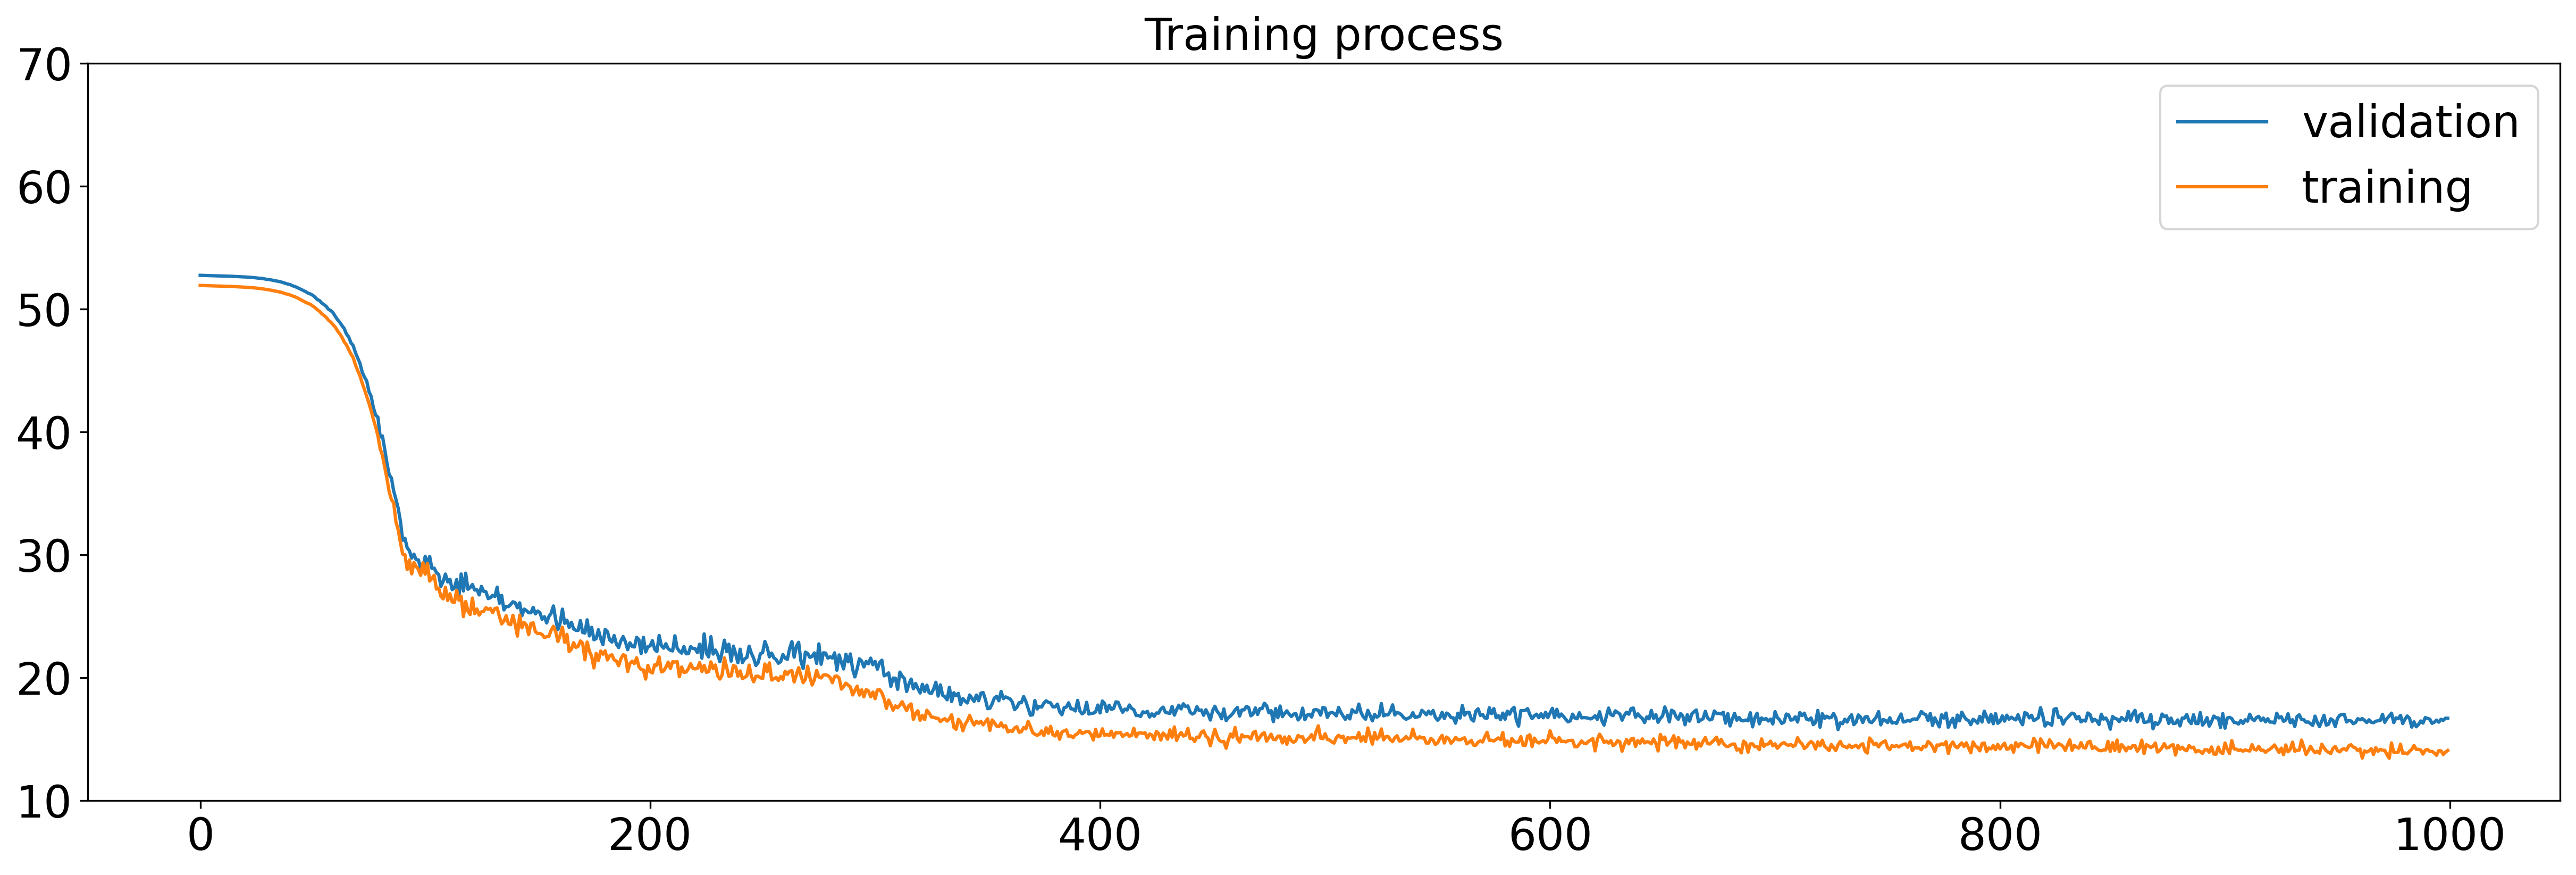

In [89]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)
plt.plot(val_loss_list_rmse[0:1000], label='validation')
plt.plot(train_loss_list_rmse[0:1000], label='training')
plt.legend(fontsize=20)
plt.ylim((10, 70))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.title('Training process', fontsize=20)
plt.savefig(r'./Figures/loss_percentage_5_7.png', dpi = 300)

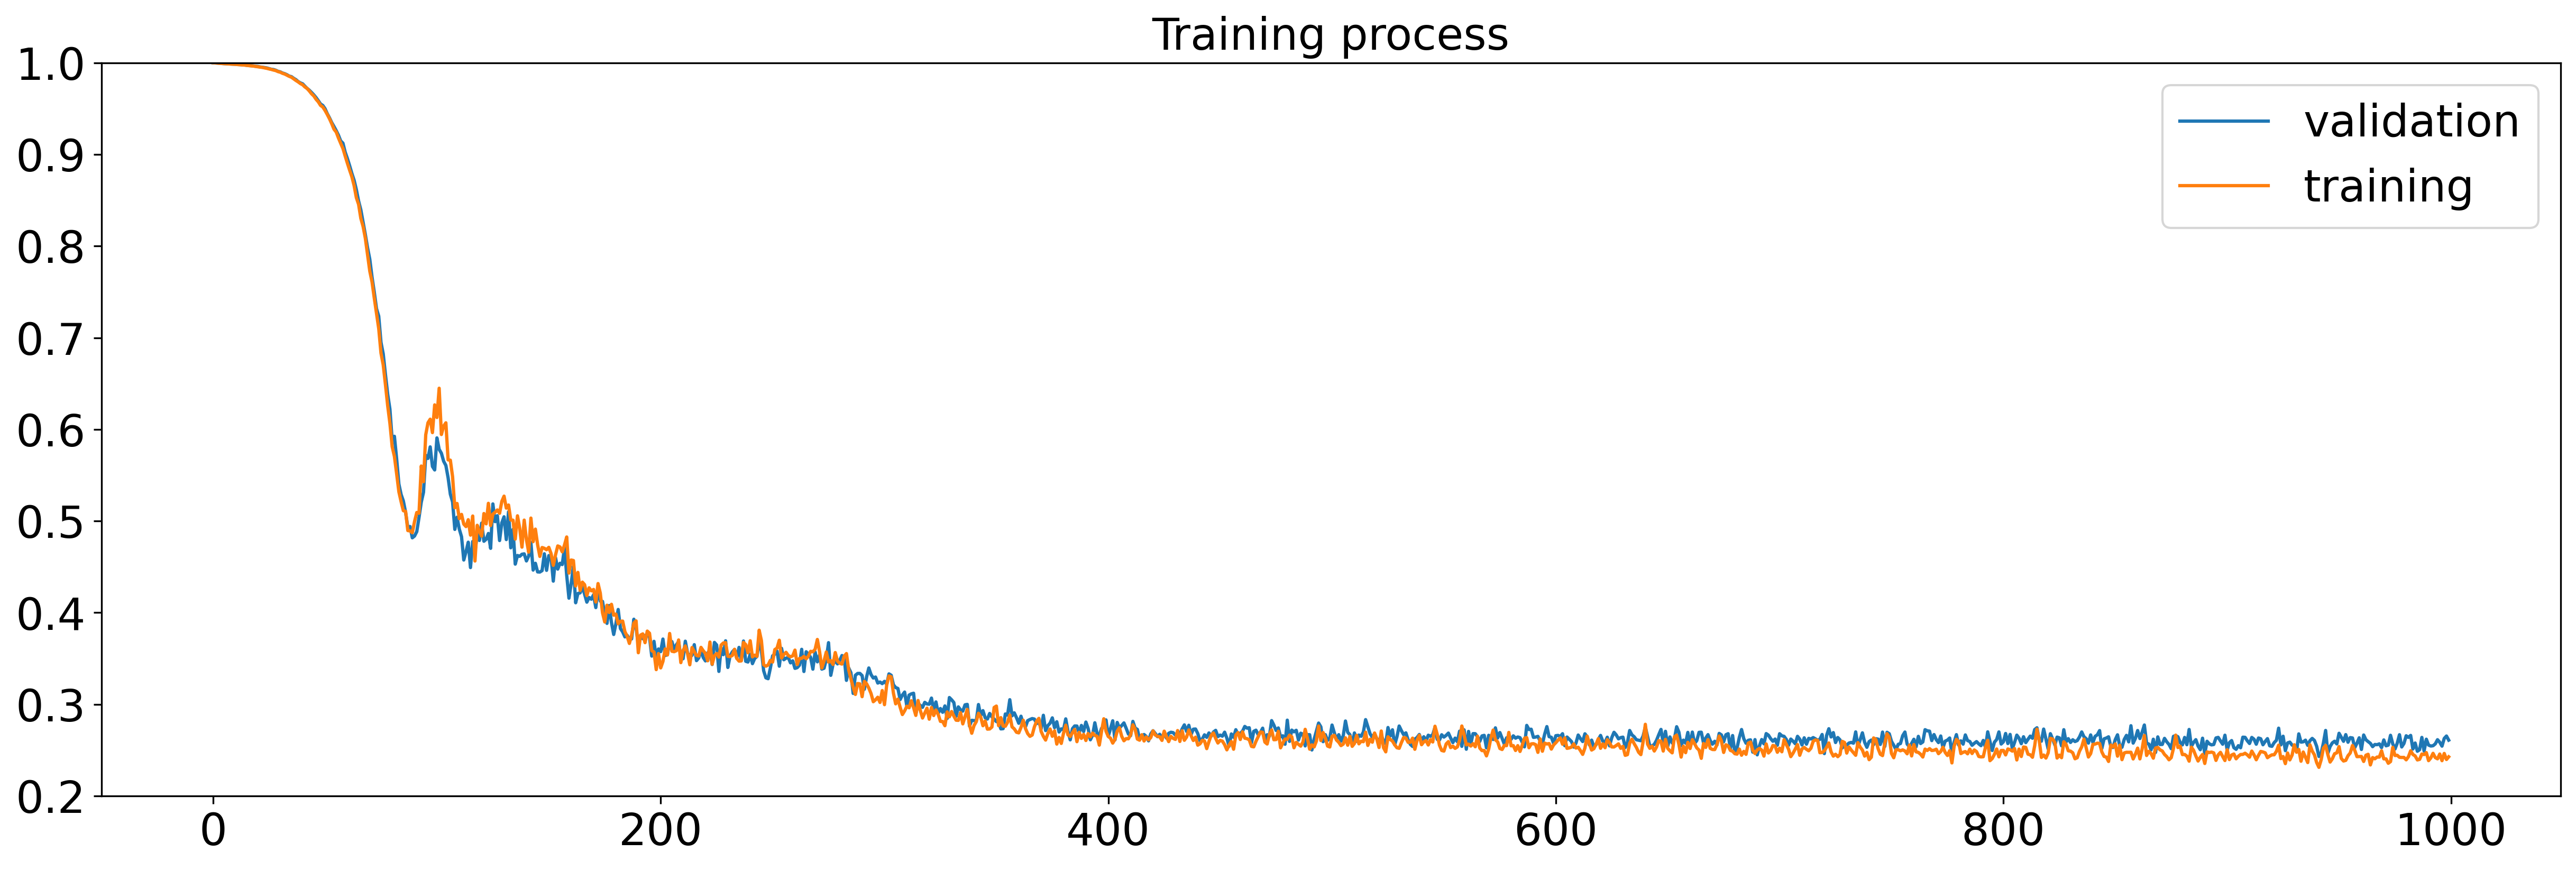

In [90]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)
plt.plot(val_loss_list[0:1000], label='validation')
plt.plot(train_loss_list[0:1000], label='training')
plt.legend(fontsize=20)
plt.ylim((0.2,1))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.title('Training process', fontsize=20)
plt.savefig(r'./Figures/loss_rmse_5_7.png', dpi = 300)

In [102]:
for name, param in model.state_dict().items():
    print(name, param.size())

TypeError: size() received an invalid combination of arguments - got (tuple), but expected one of:
 * (int dim)
      didn't match because some of the arguments have invalid types: (!tuple!)
 * ()
      didn't match because some of the arguments have invalid types: (!tuple!)
 * (name dim)
      didn't match because some of the arguments have invalid types: (!tuple!)


In [114]:
from torch.nn.modules.module import _addindent
import torch
import numpy as np
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr

# Test

print(torch_summarize(model))

Net (
  (conv1): GCNConv(365, 64), weights=((64,), (64, 365)), parameters=23424
  (conv2): GCNConv(64, 24), weights=((24,), (24, 64)), parameters=1560
  (conv3): GCNConv(24, 12), weights=((12,), (12, 24)), parameters=300
  (conv4): GCNConv(24, 64), weights=((64,), (64, 24)), parameters=1600
  (conv5): GCNConv(64, 24), weights=((24,), (24, 64)), parameters=1560
  (conv6): GCNConv(24, 12), weights=((12,), (12, 24)), parameters=300
  (lstm): LSTM(1, 12, num_layers=4, batch_first=True), weights=((48, 1), (48, 12), (48,), (48,), (48, 12), (48, 12), (48,), (48,), (48, 12), (48, 12), (48,), (48,), (48, 12), (48, 12), (48,), (48,)), parameters=4464
)


In [39]:
from torch import nn

In [74]:
rnn = nn.LSTM(1, 12, 4, batch_first=True)
input = X_Speed.float()
h0 = torch.randn(4, 4698, 12)
c0 = torch.randn(4, 4698, 12)
output, (hn, cn) = rnn(input, (h0, c0))

In [47]:
X_Speed.float()

tensor([[[70.5480],
         [71.8291],
         [71.4633],
         ...,
         [58.4717],
         [58.8700],
         [70.8601]],

        [[61.7979],
         [63.7217],
         [66.9656],
         ...,
         [52.0571],
         [57.8116],
         [61.4658]],

        [[69.0320],
         [69.9044],
         [73.3595],
         ...,
         [50.5909],
         [59.9541],
         [57.8223]],

        ...,

        [[54.1577],
         [53.6809],
         [54.0295],
         ...,
         [53.0975],
         [55.1278],
         [59.3126]],

        [[29.5948],
         [40.5396],
         [52.5144],
         ...,
         [59.9734],
         [56.0481],
         [63.9449]],

        [[54.9153],
         [58.7277],
         [57.8243],
         ...,
         [64.3893],
         [48.4345],
         [45.5967]]])

In [78]:
output.shape

torch.Size([4698, 12, 12])

In [79]:
hn[3].shape

torch.Size([4698, 12])

In [36]:
x = torch.randn(3, 4)
print(x)
x = x[:, :, None]
print(x)

tensor([[ 0.9391,  1.4016, -0.4887,  0.6554],
        [ 0.7245,  2.0128, -0.6742,  0.2129],
        [ 1.9458, -0.7181,  1.1993, -0.7341]])
tensor([[[ 0.9391],
         [ 1.4016],
         [-0.4887],
         [ 0.6554]],

        [[ 0.7245],
         [ 2.0128],
         [-0.6742],
         [ 0.2129]],

        [[ 1.9458],
         [-0.7181],
         [ 1.1993],
         [-0.7341]]])


In [35]:
x

tensor([[[-1.5062],
         [-0.0602],
         [-0.1603],
         [ 0.3584]],

        [[-1.2441],
         [ 0.4400],
         [-1.7842],
         [ 1.2092]],

        [[-0.6348],
         [ 0.9065],
         [ 0.7899],
         [ 1.5284]]])

In [81]:
T1 = torch.Tensor([[1,2],[3,4]])
T2 = torch.Tensor([[0,3],[4,1]])
T3 = torch.Tensor([[4,3],[2,5]])
print(T1)
print(T2)
print(T3)

tensor([[1., 2.],
        [3., 4.]])
tensor([[0., 3.],
        [4., 1.]])
tensor([[4., 3.],
        [2., 5.]])


In [84]:
t = torch.cat((T1, T2, T3), -1)
print(t)

tensor([[1., 2., 0., 3., 4., 3.],
        [3., 4., 4., 1., 2., 5.]])
